In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [2]:
df = pd.read_csv('cities.csv')


In [26]:
cities = ['Москва', 'Санкт-Петербург', 'Новосибирск', 'Екатеринбург', 'Нижний Новгород', 'Казань', 'Челябинск',
          'Омск', 'Самара', 'Ростов-на-Дону', 'Уфа', 'Красноярск', 'Воронеж', 'Пермь', 'Волгоград', 'Краснодар',
         'Саратов', 'Тюмень', 'Тольятти', 'Ижевск', 'Барнаул', 'Ульяновск', 'Иркутск', 'Хабаровск', 'Ярославль',
         'Владивосток', 'Махачкала', 'Томск', 'Оренбург', 'Кемерово']
coord = dict()

In [27]:
import math
for city in cities:
    cur_selection = df.loc[df['address'].str.contains('г '+city)].reset_index(drop=True)
    assert len(cur_selection)==1
    coord[city] = (cur_selection['geo_lon'][0]/180*math.pi, cur_selection['geo_lat'][0]/180*math.pi)

In [28]:
def get_coord(coord):
    return np.cos(coord[0]), np.sin(coord[0]), np.cos(coord[0])*np.sin(coord[1])
def dist(coord1, coord2):
    fi = np.zeros(3)
    fi[0], fi[1], fi[2] = get_coord(coord1)
    se = np.zeros(3)
    se[0], se[1], se[2] = get_coord(coord2)
    scalar = sum([fi[i]*se[i] for i in range(3)])
    vect = np.zeros(3)
    vect[0] = fi[1]*se[2]-fi[2]*se[1]
    vect[1] = fi[0]*se[2]-fi[2]*se[0]
    vect[2] = fi[0]*se[1]-fi[1]*se[0]
    vect_norm = np.sqrt(sum([x**2 for x in vect]))
    return np.arctan2(vect_norm, scalar)

In [29]:
dist(coord['Москва'], coord['Санкт-Петербург'])

0.12138585553372636

In [54]:
draw_coord = dict()
for i in range(30):
    draw_coord[cities[i]] = ((np.random.rand()+i/5)*2, (np.random.rand()+i%5)*2)
    

In [30]:
def calc_p_star(score, temperature):
    return np.exp(-score / temperature)
def get_score(permutation):
    score = 0
    for i in range(len(permutation)):
        j = (i+1)%len(permutation)
        score += dist(coord[cities[permutation[i]]], coord[cities[permutation[j]]])
    return score
        
        

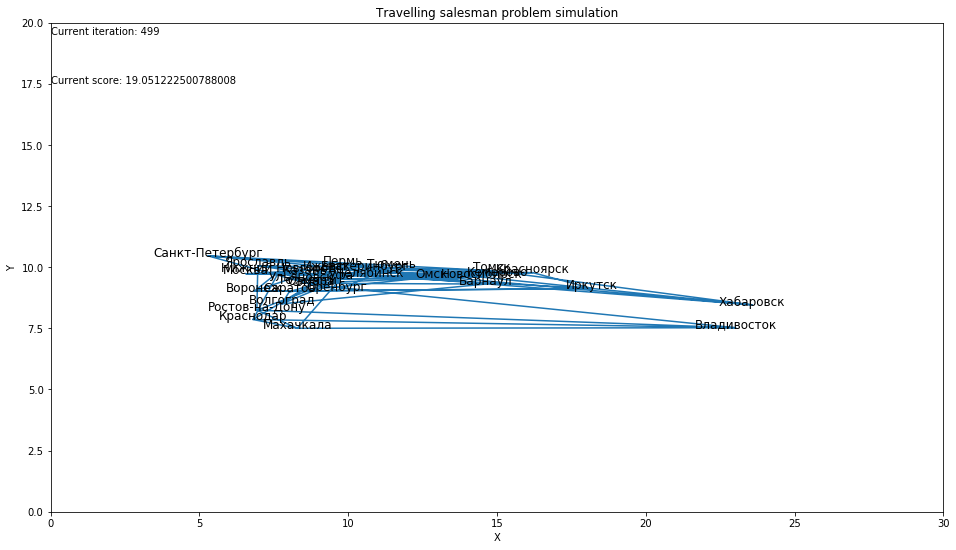

In [101]:
annealing_rate = 0.995
chosen_permutation = np.random.permutation(30)
chosen_score = get_score(chosen_permutation)
temperature = 30


fig, ax = plt.subplots(figsize=(16, 9))
xdata, ydata = [], []
ln, = plt.plot([], [])
chosen_coord = coord.copy()
ax.set_ylabel('Y')
ax.set_xlabel('X')
ax.set_title('Travelling salesman problem simulation')
for k,v in chosen_coord.items():
    chosen_coord[k] = (v[0]*10, v[1]*10)
time_texts = [ax.text(chosen_coord[cities[i]][0], chosen_coord[cities[i]][1], cities[i], horizontalalignment='center', fontsize=12) for i in range(30)]
energy_text = ax.text(0, 17.5, '')
moment_text = ax.text(0, 19.5, '')
drawers = time_texts
drawers.append(ln)
drawers.append(energy_text)
drawers.append(moment_text)

def init():
    ax.set_xlim(0, 30)
    ax.set_ylim(0, 20)
    return drawers


def update(iteration):
    global xdata
    global ydata
    was_x = xdata.copy()
    was_y = ydata.copy()
    
    global chosen_permutation
    global chosen_score
    global temperature
    cur_permutation = chosen_permutation
    ind = np.random.randint(30)
    n_ind = np.random.randint(30)
    cur_permutation[ind], cur_permutation[n_ind] = cur_permutation[n_ind], cur_permutation[ind]
    cur_score = get_score(cur_permutation)
    acceptance_ratio = calc_p_star(cur_score, temperature)/calc_p_star(chosen_score, temperature)
#     print(cur_score, chosen_score)
#     print(acceptance_ratio)
    u = np.random.rand()
    if u < acceptance_ratio:
        chosen_permutation = cur_permutation
        chosen_score = cur_score
        xdata = []
        ydata = []
        for i in range(len(chosen_permutation)):
            j = (i+1)%len(chosen_permutation)
            dx = chosen_coord[cities[chosen_permutation[i]]][0] - chosen_coord[cities[chosen_permutation[j]]][0]
            dy = chosen_coord[cities[chosen_permutation[i]]][1] - chosen_coord[cities[chosen_permutation[j]]][1]
    #         print(dx)
    #         print(dy)
            xdata.extend(list(chosen_coord[cities[chosen_permutation[j]]][0]+np.linspace(0,1,20)*dx))
            ydata.extend(list(chosen_coord[cities[chosen_permutation[j]]][1]+np.linspace(0,1,20)*dy))
        ln.set_data(xdata, ydata)
    energy_text.set_text(f'Current score: {chosen_score}')
    moment_text.set_text(f'Current iteration: {iteration}')
    temperature*=annealing_rate
    return drawers

anim = FuncAnimation(fig, update, frames=500,
                    init_func=init, blit=True)
HTML(anim.to_html5_video())